# Chapter 2 - Image Enhancement

Will go over methods to transform images, sharpening, blurring, etc.

JuliaImages are 2D arrays, with each pixel either a scalar (grayscale) or a 1D array (RGB)

In [1]:
using Images

In [2]:
# Utility function to reload image we're primarily working with in this chapter
function reload_cats()
    load("../sample-images/cats-3061372_640.jpg")
end;

In [3]:
img = reload_cats()
img[1:1, 1:1, :]

1×1×1 Array{RGBX{N0f8},3} with eltype RGBX{Normed{UInt8,8}}:
[:, :, 1] =
 RGBX{N0f8}(0.349,0.282,0.212)

In this case, we see that it's an RGB image, 0-1 (scaled by 1/255). This works until you want to manipulate pixels, in which the `channelview` function needs to be invoked

In [4]:
using ImageView

In [5]:
ch_view = channelview(img)
ch_view

3×360×640 reinterpret(N0f8, reshape(mappedarray(x->MappedArrays.convert($(Expr(:static_parameter, 1)), x), y->MappedArrays.convert($(Expr(:static_parameter, 1)), y), ::Array{RGBX{N0f8},2}), 1, 360, 640)):
[:, :, 1] =
 0.349  0.353  0.345  0.329  0.302  …  0.106  0.106  0.114  0.125  0.122
 0.282  0.286  0.278  0.263  0.239     0.071  0.071  0.078  0.09   0.086
 0.212  0.216  0.212  0.196  0.173     0.051  0.051  0.059  0.071  0.067

[:, :, 2] =
 0.365  0.365  0.357  0.337  0.314  …  0.122  0.122  0.129  0.141  0.137
 0.298  0.298  0.29   0.271  0.251     0.086  0.086  0.094  0.106  0.102
 0.227  0.227  0.224  0.204  0.184     0.067  0.067  0.075  0.086  0.082

[:, :, 3] =
 0.373  0.373  0.365  0.345  0.318  …  0.125  0.122  0.129  0.137  0.133
 0.306  0.306  0.298  0.278  0.255     0.09   0.086  0.094  0.102  0.098
 0.235  0.235  0.231  0.212  0.188     0.071  0.067  0.075  0.082  0.078

...

[:, :, 638] =
 0.396  0.416  0.424  0.42   0.427  …  0.306  0.294  0.294  0.282  0.259
 0.345 

With this mapping, then we can manipulate pixels. Try updating colors with value >0.7 to force to 0.9. This gives a fun "filter" effect.

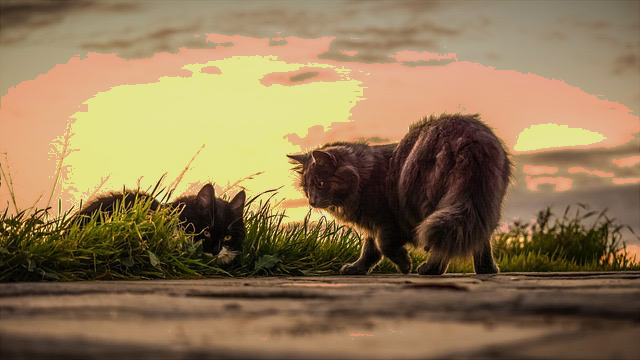

In [6]:
ch_view[ch_view .> 0.7] .= 0.9
img

#### Converting numbers to colors

Start with a random array

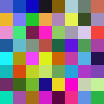

In [7]:
random_img = rand(3, 8, 8)
r_im = colorview(RGB, random_img)
r_im

Alternatively, if the order is mixed up, `permuteddimsview` exists to rearrange

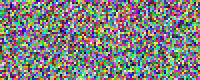

In [8]:
random_img_array = rand(40, 100, 3); # height, width, channel
img_perm = permuteddimsview(random_img_array, (3, 1, 2))
r_im = colorview(RGB, Float16.(img_perm))
r_im

### Saturation

To increase saturation, we'll increase the value 10%, clipping at 1.

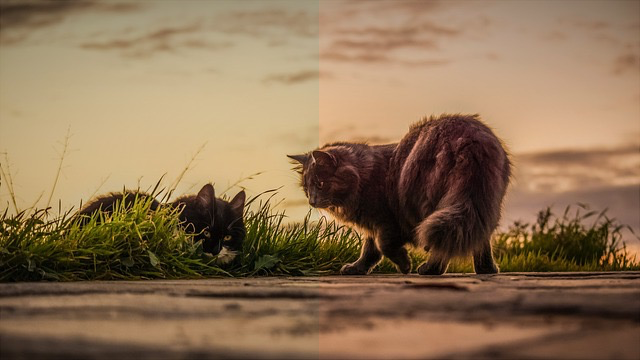

In [9]:
img = reload_cats() # Reload image
img_ch_view = channelview(img); # extract channels
img_ch_view = permuteddimsview(img_ch_view, (2, 3, 1)) # set channels to last dim
x_coords = Int(size(img, 2) /2):size(img,2 ); # Take the right half of the image
img_ch_view[:, x_coords, 1] = min.(img_ch_view[:, x_coords, 1] .* 1.1, 1) # Multiply by 1.1
img

Next, we'll try 20% to the green layer, then 40% to the blue channel

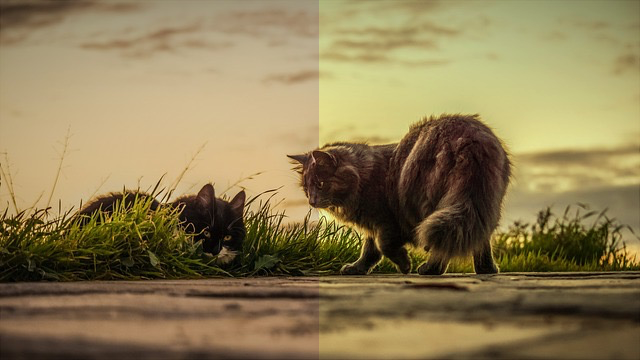

In [10]:
img_ch_view[:, x_coords, 2] = min.(img_ch_view[:, x_coords, 2] .* 1.2, 1) # Green
display(img)

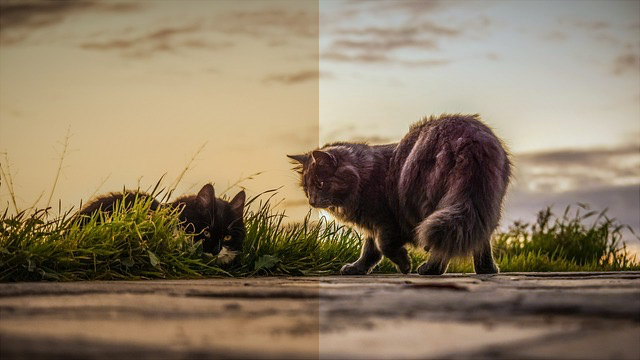

In [11]:
img_ch_view[:, x_coords, 3] = min.(img_ch_view[:, x_coords, 3] .* 1.4, 1) # Blue
display(img)

### Converting to grayscale

This is pretty easy, there's a `Gray` function built in to images

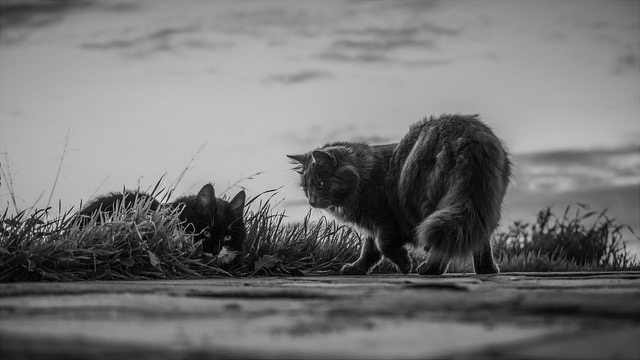

In [12]:
img = reload_cats()
grayscaled = Gray.(img)
display(grayscaled)

## Custom Filters

We can imagine more sophisticated filters. For example, perhaps we want to generate a color-splash filter.

We can do this by using a combination of gray and RGB mappings of the image. Then, use a mask to keep track of the pixels we want to keep based on their values.

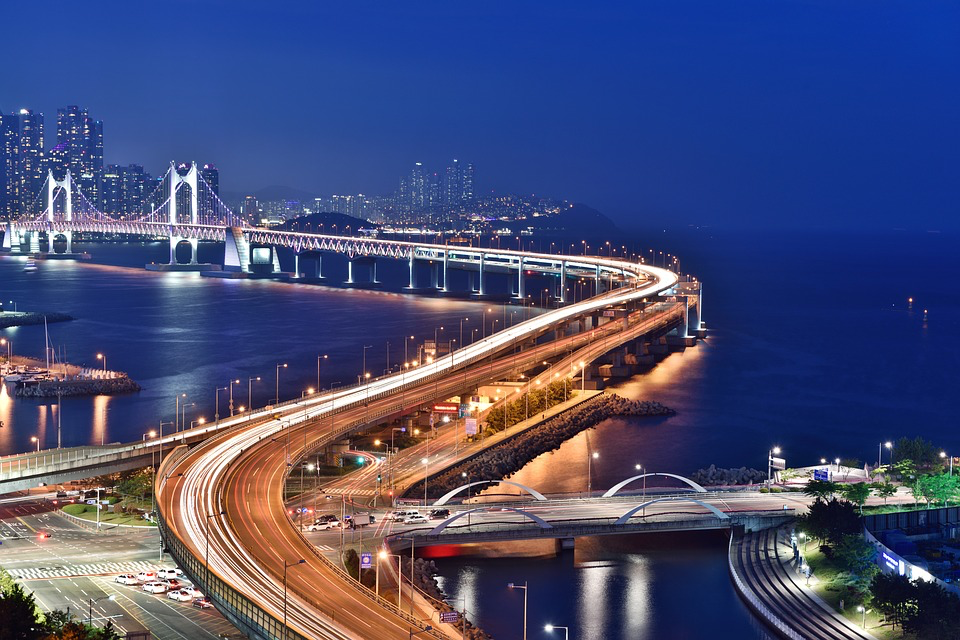

In [13]:
# Preview image
img = load("../sample-images/busan-night-scene.jpg")

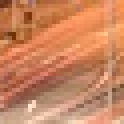

In [14]:
# Load the image, and a gray version
img_gray = RGB.(Gray.(img));

# Channel views
channel_view = channelview(img);
gray_channel_view = channelview(img_gray);

# Arrange correctly 
img_arr = permuteddimsview(channel_view, (2,3,1));
img_gray_arr = permuteddimsview(gray_channel_view, (2,3,1));

# Generate mask
img_mask = fill(true, size(img)) # all values start true
spot_height = 430:460  # Ranges with the colors we wnat to keep
spot_width = 430:460
img[spot_height, spot_width]

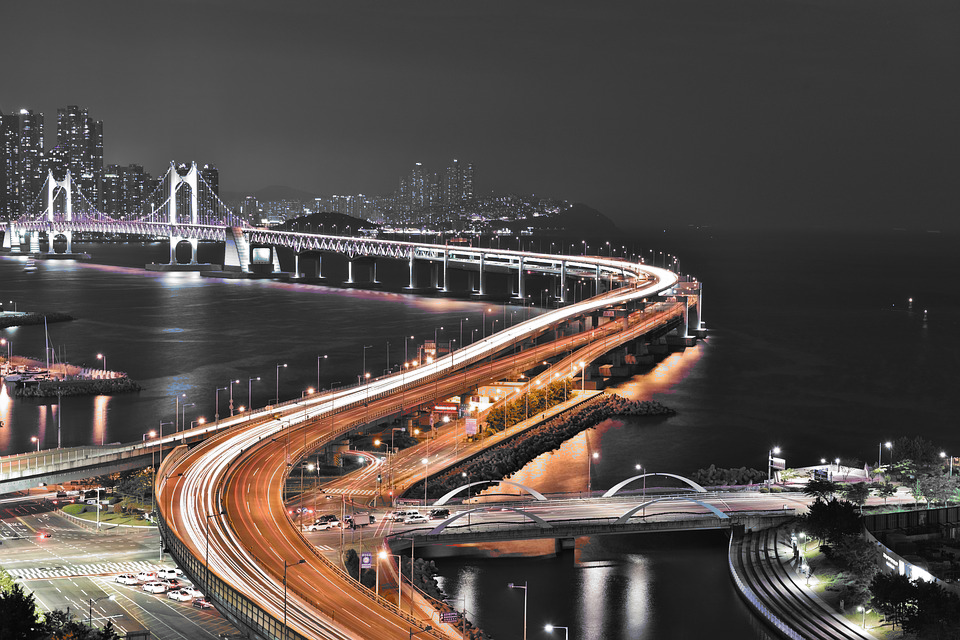

In [15]:
for channel_id = 1:3
    # Select current channel, crop to areas of interest
    curr_channel = view(img_arr, :, :, channel_id)
    current_channel_area = curr_channel[spot_height, spot_width, :]
    
    # Get max/min vals
    ch_min = minimum(current_channel_area)
    ch_max = maximum(current_channel_area)
    
    # Merge existing mask with current channel mask
    ch_mask = ch_min .< curr_channel .< ch_max
    img_mask = img_mask .& ch_mask
end

# Apply
img_masked = img_arr .* img_mask .+ img_gray_arr .* .~(img_mask);
final = colorview(RGB, permutedims(img_masked, (3,1,2)))
final

## Applying image filters 

There's a whole package for image filtering, `ImageFiltering.jl`.

### Adding padding

First, constant padding, 25 pixels

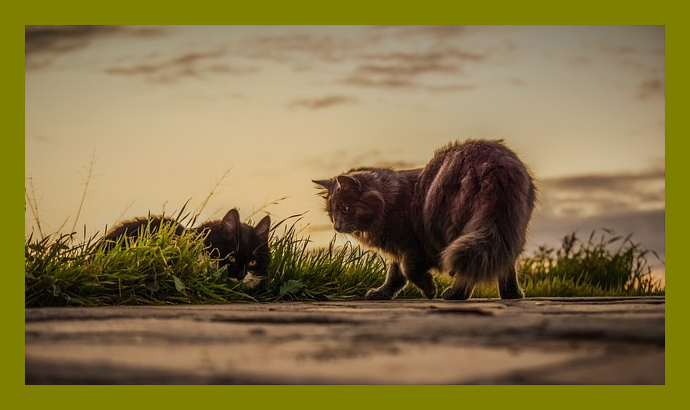

In [16]:
pad_vert = 25
pad_horiz = 25
pad_color = RGB4{N0f8}(0.5, 0.5, 0.)

img = reload_cats()
img = padarray(img, Fill(pad_color, (pad_vert, pad_horiz)))
img = parent(img) # Resets indicies
img

Add a border by duplication -

- `:replicate` will copy border pixels
- `:circular` wrap around
- `:symmetric` reflect relative to a position
- `:reflect` border reflect relative to the edge

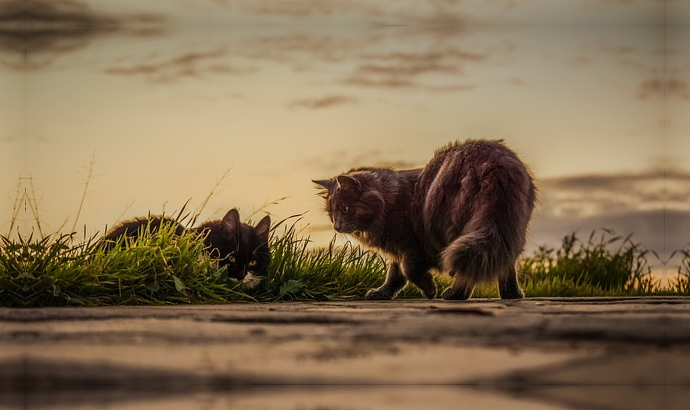

In [17]:
img = reload_cats()
img = padarray(img, Pad(:reflect, pad_vert, pad_horiz))
img = parent(img) # reset indicies
img

### Blurring

Gaussian kernel blurring function from `ImageFiltering`

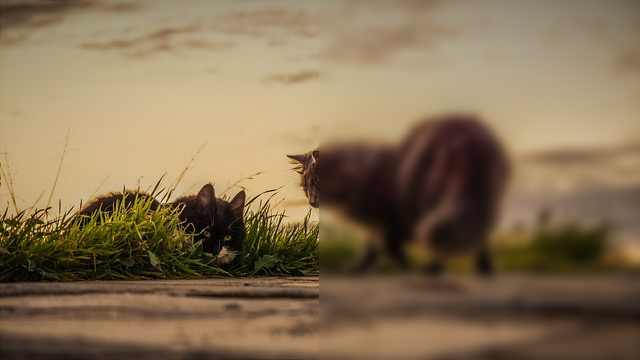

In [18]:
using ImageFiltering

img = reload_cats()
img_area_right = 320:640

right_side = img[:, img_area_right]
right_blur = imfilter(right_side, Kernel.gaussian(5))
img[:, img_area_right] = right_blur
img

We can imagine something more sophisticated. Create a box in the middle of the image and blur out anything outside of that box, like the dynamic bar on instagram

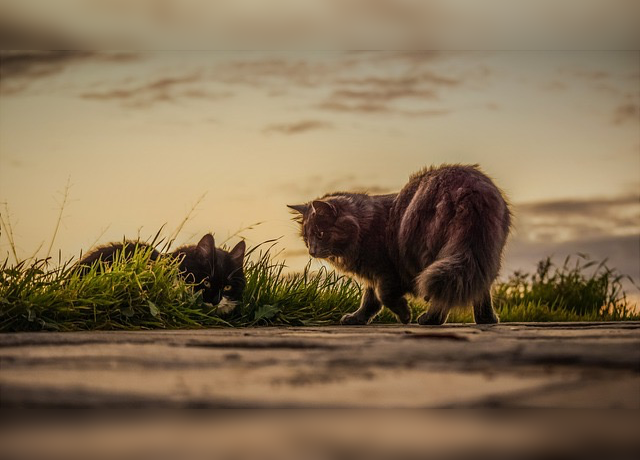

In [19]:
border_size = 50
kernel_val = 10
img = reload_cats()

# pad borders
img = padarray(img, Pad(:reflect, border_size, 0))
img = parent(img)

# On the new borders, add blurring
area_top = 1:border_size
img[area_top, :] = imfilter(img[area_top, :], Kernel.gaussian(kernel_val))

area_bottom = size(img, 1) - border_size:size(img, 1)
img[area_bottom, :] = imfilter(img[area_bottom, :], Kernel.gaussian(kernel_val))

img

### Sharpening

Last, we'll look at sharpening, which just applies a gaussian smoothing kernel

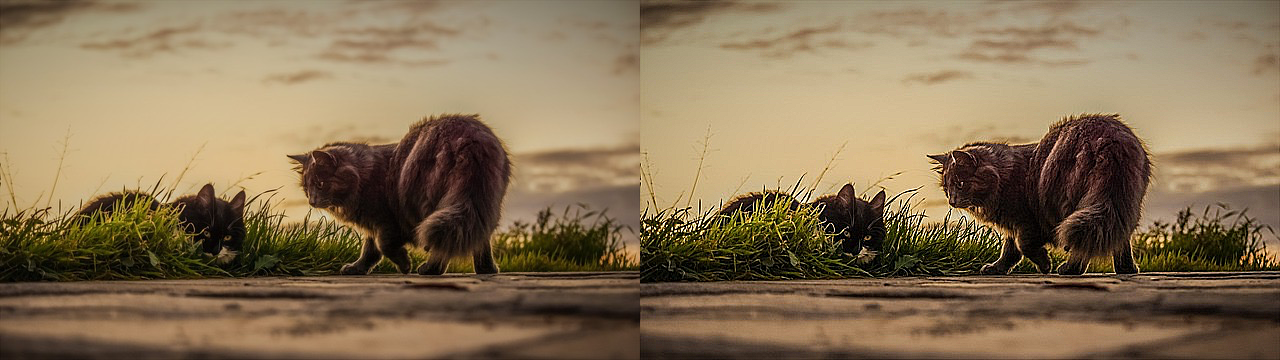

In [20]:
smoothing = 1
intensity = 2

img = reload_cats()
imgb = imfilter(img, Kernel.gaussian(smoothing));

# Convert to floats
img_array = Float16.(channelview(img));
imgb_array = Float16.(channelview(imgb));

# Create sharpened version
sharpened = img_array .* (1 + intensity) .+ imgb_array .* (-intensity);
sharpened = max.(sharpened, 0);
sharpened = min.(sharpened, 1);

mosaicview(img, colorview(RGB, sharpened), ncol=2)
